## Imports

In [1]:
# Standard library imports
import os
import random
import pickle

# Data analysis packages
import numpy as np
import pandas as pd
from scipy.signal import correlate, correlation_lags
from scipy.ndimage import gaussian_filter1d

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import FancyArrow, Patch, Circle
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D

# Image processing packages
import imageio
from PIL import Image, ImageSequence

# Braingeneers packages for analysis
import braingeneers
import braingeneers.data.datasets_electrophysiology as ephys
from braingeneers.analysis.analysis import SpikeData, read_phy_files, load_spike_data, burst_detection, randomize_raster

# Helper Functions

In [2]:
# Function to get neuron positions
def get_neuron_positions(spike_data):
    # Extract neuron positions from spike_data
    neuron_x = []
    neuron_y = []
    for neuron in spike_data.neuron_data['positions'].values():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])
    neuron_positions = np.array([neuron_x, neuron_y]).T
    return neuron_positions

def calculate_mean_firing_rates(spike_data):
    mean_firing_rates = []
    for neuron_spikes in spike_data.train:
        num_spikes = len(neuron_spikes)
        time_duration = spike_data.length / 1000  # Assuming spike times are in milliseconds
        firing_rate = num_spikes / time_duration
        mean_firing_rates.append(firing_rate)

    return np.array(mean_firing_rates)

def plot_raster(sd, title):
    idces, times = sd.idces_times()
    # Adjust the figsize parameter to change the figure size; (width, height) in inches
    fig, ax = plt.subplots(figsize=(10, 6))  # Example: 10 inches wide by 6 inches tall

    ax.scatter(times/1000, idces, marker='|', s=1)
    ax.set_xlabel("Time(s)")
    ax.set_ylabel('Unit #')
    ax.set_title(title)
    plt.show()

def firing_plotter(sd, global_min_rate, global_max_rate):
    # Custom colormap from pale red/pink to dark red/black
    colors = ["#ffcccb", "#ff6961", "#ff5c5c", "#ff1c00", "#bf0000", "#800000", "#400000", "#000000"]
    cmap_name = "custom_red_black"
    n_bins = 100  # More bins will give us a finer gradient
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

    firing_rates = calculate_mean_firing_rates(sd)
    neuron_x, neuron_y = [], []
    # Extract neuron positions
    for i, neuron in sd.neuron_data['positions'].items():
        neuron_x.append(neuron['position'][0])
        neuron_y.append(neuron['position'][1])

    plt.figure(figsize=(8, 6))
    # Plotting a small pale blue square at each neuron position
    plt.scatter(neuron_x, neuron_y, s=10, c='#add8e6', marker='s', alpha=0.6)
    scatter = plt.scatter(neuron_x, neuron_y, s=firing_rates*1.5, c=firing_rates, alpha=0.6, cmap=cm, vmin=global_min_rate, vmax=75)

    # Creating dummy plots for the legend
    for rate in [20, 40, 60]:  # Example firing rates
        plt.scatter([], [], s=rate*1.5, c='gray', alpha=0.6, label=f'{rate} Hz')

    plt.title("Animation of Firing Rates for Synthetic Wave-Propagation Data")
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.colorbar(scatter, label='Firing Rate (Hz)')
    plt.gca().invert_yaxis()

    # Adding the legend for sizes with title
    plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Firing Rate', loc='upper right')

    # plt.show()

## Data Generator

In [17]:
# def generate_overlap_spike_data(total_duration_ms, num_propagations, rows, cols, overlap_duration_ms, break_duration_ms, sparsity_factor=20):
#     N_channels = rows * cols
#     # Calculate adjusted segment and row durations
#     adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
#     segment_duration_ms = adjusted_total_duration_ms / num_propagations
    
#     # Initialize positions and neuron_data
#     positions = [(x, y) for x in range(rows) for y in range(cols)]
#     neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}
    
#     # Initialize train with empty lists for each channel
#     train_patterned_overlap = [[] for _ in range(N_channels)]
    
#     # Generate spike times with specified overlap and breaks
#     for propagation in range(num_propagations):
#         segment_start = propagation * (segment_duration_ms + break_duration_ms)
        
#         for row in range(rows):
#             row_start = segment_start + (row * (segment_duration_ms / rows - overlap_duration_ms))
#             spike_time_start = row_start
#             spike_time_end = spike_time_start + (segment_duration_ms / rows) + overlap_duration_ms
            
#             for col in range(cols):
#                 channel_index = row * cols + col
#                 # Increase the sparsity_factor to make the firing sparser
#                 spike_times = np.linspace(spike_time_start, spike_time_end, int(segment_duration_ms / rows / sparsity_factor))
#                 train_patterned_overlap[channel_index].extend(spike_times)
    
#     # Convert lists to numpy arrays
#     train_patterned_overlap = [np.array(times) for times in train_patterned_overlap]
    
#     # Create the SpikeData object for the new dataset
#     spike_data_patterned_overlap = SpikeData(train=train_patterned_overlap, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)
    
#     return spike_data_patterned_overlap


def generate_overlap_spike_data(total_duration_ms, num_propagations, rows, cols, overlap_duration_ms, break_duration_ms, sparsity_factor=20, slant_factor_ms_per_col=1):
    N_channels = rows * cols
    # Calculate adjusted segment and row durations
    adjusted_total_duration_ms = total_duration_ms - (break_duration_ms * (num_propagations - 1))
    segment_duration_ms = adjusted_total_duration_ms / num_propagations
    
    # Initialize positions and neuron_data
    positions = [(x, y) for x in range(rows) for y in range(cols)]
    neuron_data = {'positions': {i: {'position': positions[i]} for i in range(N_channels)}}
    
    # Initialize train with empty lists for each channel
    train_patterned_overlap = [[] for _ in range(N_channels)]
    
    # Generate spike times with specified overlap, breaks, and diagonal slant
    for propagation in range(num_propagations):
        segment_start = propagation * (segment_duration_ms + break_duration_ms)
        
        for row in range(rows):
            row_start = segment_start + (row * (segment_duration_ms / rows - overlap_duration_ms))
            
            for col in range(cols):
                channel_index = row * cols + col
                # Adjust spike start time based on column position to create the slant
                spike_time_start = row_start + (col * slant_factor_ms_per_col)
                spike_time_end = spike_time_start + (segment_duration_ms / rows) + overlap_duration_ms
                
                spike_times = np.linspace(spike_time_start, spike_time_end, int(segment_duration_ms / rows / sparsity_factor))
                train_patterned_overlap[channel_index].extend(spike_times)
    
    # Convert lists to numpy arrays
    train_patterned_overlap = [np.array(times) for times in train_patterned_overlap]
    
    # Create the SpikeData object for the new dataset
    spike_data_patterned_overlap = SpikeData(train=train_patterned_overlap, N=N_channels, length=total_duration_ms, neuron_data=neuron_data)
    
    return spike_data_patterned_overlap


## Data

In [19]:
# overlap_spike_data = generate_overlap_spike_data(
#     total_duration_ms=60 * 1000,  # 60 seconds in milliseconds
#     num_propagations=10,
#     rows=16,
#     cols=16,
#     overlap_duration_ms=100,
#     break_duration_ms=2000,
#     sparsity_factor=10 
#      # 5 seconds
# )

overlap_spike_data = generate_overlap_spike_data(
    total_duration_ms=60 * 1000,  # 60 seconds in milliseconds
    num_propagations=10,
    rows=16,
    cols=16,
    overlap_duration_ms=100,
    break_duration_ms=2000,
    sparsity_factor=10,
    slant_factor_ms_per_col=20
     # 5 seconds
)

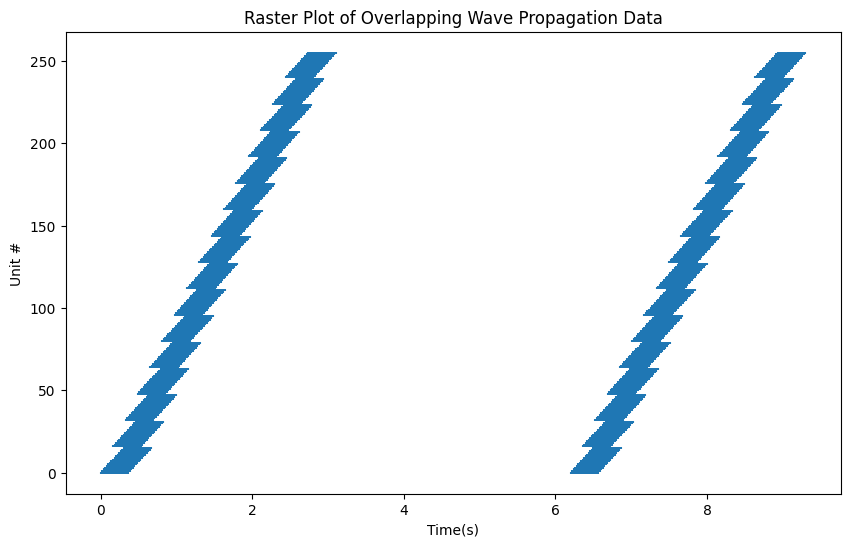

In [20]:
plot_raster(overlap_spike_data.subtime(0, 10000), "Raster Plot of Overlapping Wave Propagation Data")

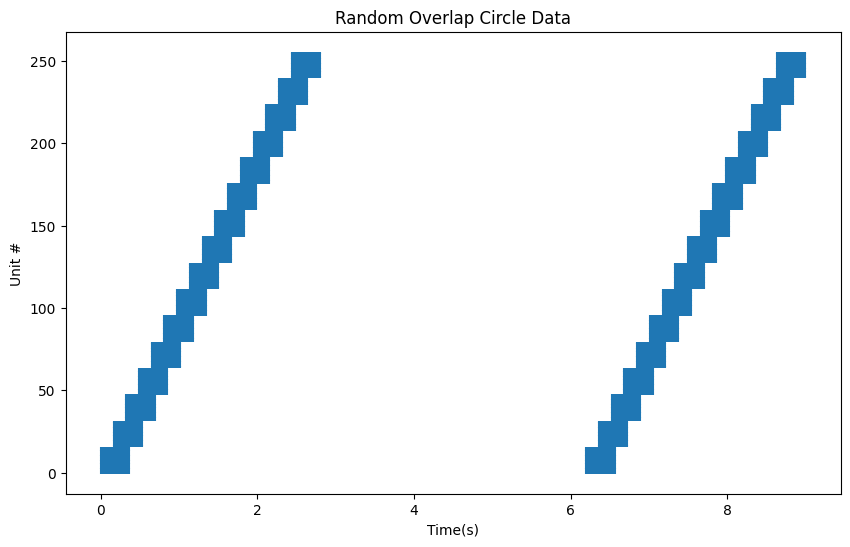

In [6]:
plot_raster(overlap_spike_data.subtime(0, 10000), "Random Overlap Circle Data")

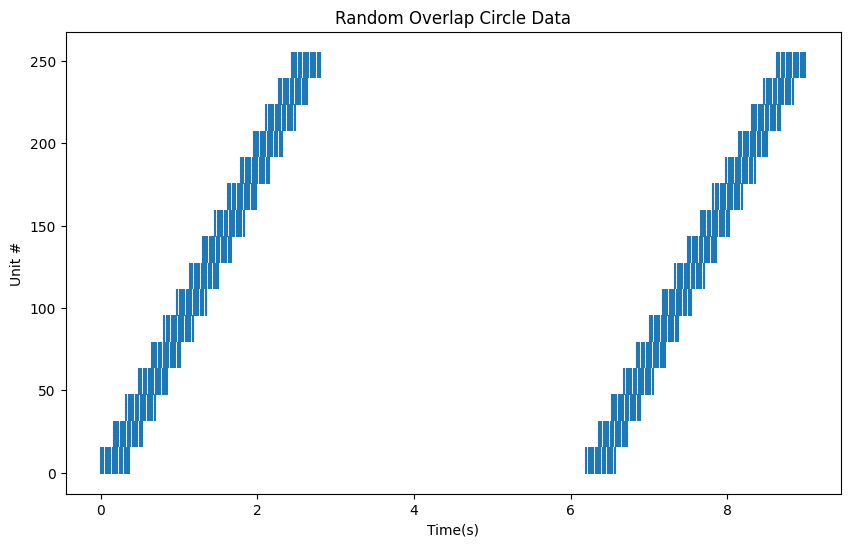

In [19]:
plot_raster(overlap_spike_data.subtime(0, 10000), "Random Overlap Circle Data")

In [7]:
# Save the spikedata with pickle
with open('data/linear_overlap_spike_data.pkl', 'wb') as f:
    pickle.dump(overlap_spike_data, f)